Spatial domain detection in DLPFC dataset
=====

We present our evaluation source code of DLPFC slice 151507 in this section.  
This tutorial will show you how to obtain DLPFC data from `st_datasets` and how to train stCluster.  
If you have more than one GPU in your device, you may need to set the GPU you want, or it will run at GPU:0 by default.

## Data Preparation
First, we obtain the `sc.Anndata` format DLPFC data from `st_datasets`.

/home/hanshu/anaconda3/envs/stCluster/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/home/hanshu/anaconda3/envs/stCluster/lib/python3.9/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()
/home/hanshu/anaconda3/envs/stCluster/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


>>> INFO: dataset name: dlpfc, slice id: 151507, size: (4226, 33538), cluster: 7.(0.585s)


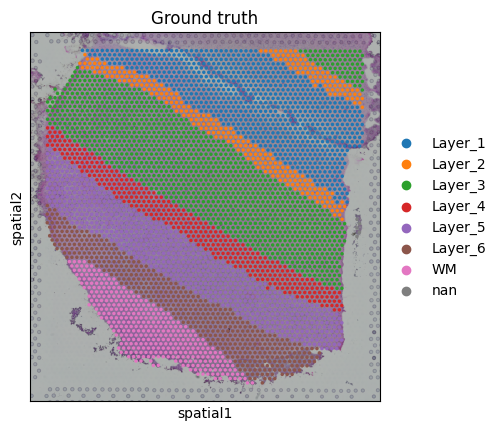

In [1]:
import scanpy as sc
from st_datasets.dataset import get_data, get_dlpfc_data

adata, n_cluster = get_data(dataset_func=get_dlpfc_data, id='151507')
sc.pl.spatial(adata, color=['cluster'], title=['Ground truth'])

## Train stCluster and clustering by the latent representation
Then, we can use the adata to generate latent representation by stCluster and evaluate the clustering performance.

>>> INFO: Input size torch.Size([4226, 3000]).
>>> INFO: Graph contains 28996 edges, average 6.861 edges per node.
>>> INFO: Build graph success!


/home/hanshu/anaconda3/envs/stCluster/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/hanshu/anaconda3/envs/stCluster/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/hanshu/anaconda3/envs/stCluster/lib/python3.9/site-packages/

>>> INFO: Finish generate precluster embedding!
>>> INFO: Finish pre-cluster, result image is saved at "None", begin to prune graph.
>>> INFO: Finish pruning graph, result image is saved at "None".
>>> INFO: Graph contains 124500 edges, average 29.460 edges per node.
>>> INFO: Build graph success!
>>> INFO: Finish model preparations, begin to train model, input data size: (4226, 3000).


>>> INFO: Training: 100%|██████████| 1000/1000 [00:16<00:00, 59.37it/s]
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.



>>> INFO: Finish embedding process, total time: 26.102s.
fitting ...
  |======================================================================| 100%


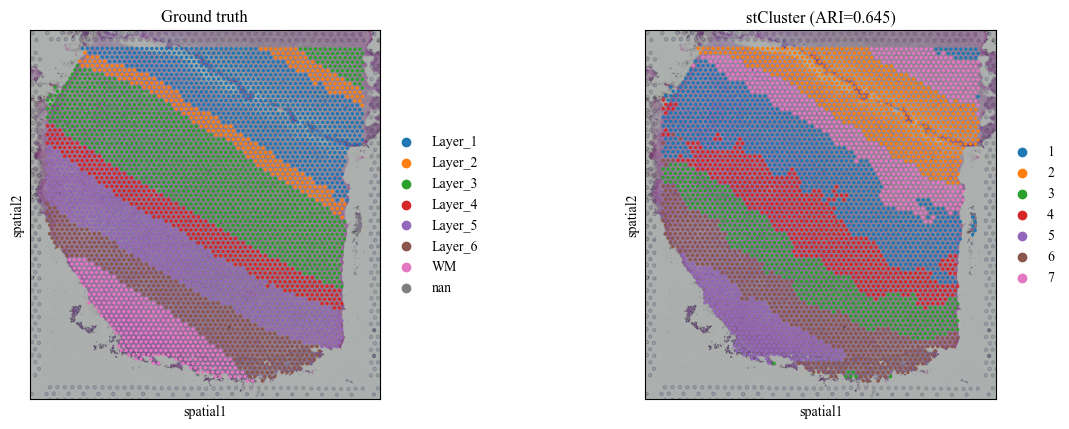

In [2]:
from stCluster.train import train
from stCluster.run import evaluate_embedding

adata, _ = train(adata, radius=150, ae_rate=0.8, adj_rate=0.2, pred_rate=0.3, seed=0)
adata, score = evaluate_embedding(adata=adata, n_cluster=n_cluster, cluster_method=['mclust'], cluster_score_method='ARI')

# # or we can easily learn representation and evaluate clustering result by `train_and_evaluate`
# from stCluster.run import train_and_evaluate
# adata, score = train_and_evaluate(adata, radius=150, ae_rate=0.8, adj_rate=0.2, pred_rate=0.3, seed=0, n_cluster=n_cluster, cluster_method=['mclust'], cluster_score_method='ARI')

sc.pl.spatial(adata, color=['cluster', 'mclust'], title=['Ground truth', 'stCluster (ARI={:.3f})'.format(score['mclust'])])

Due to the DLPFC dataset containing two type of clusters number which are clusters numbers of 7 and 5, stCluster offers hyperparameter configurations for each of these two categories. The hyperparameter settings are as follows:  
<table>
    <tr>
        <td>clusters number</td>
        <td>cutting_prob_1</td>
        <td>cutting_prob_2</td>
        <td>ae_rate</td>
        <td>adj_rate</td>
        <td>pred_rate</td>
        <td>seed</td>
    </tr>
    <tr>
        <td>7</td>
        <td>0.05</td>
        <td>0.1</td>
        <td>0.8</td>
        <td>0.2</td>
        <td>0.3</td>
        <td>0</td>
    </tr>
    <tr>
        <td>5</td>
        <td>1.0</td>
        <td>1.0</td>
        <td>0.9</td>
        <td>0.4</td>
        <td>0.2</td>
        <td>0</td>
    </tr>
</table>

## Visualization
Moreover, we visualized the latent representation by UMAP and show the trajectory inference by PAGA algorithm.

/home/hanshu/anaconda3/envs/stCluster/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


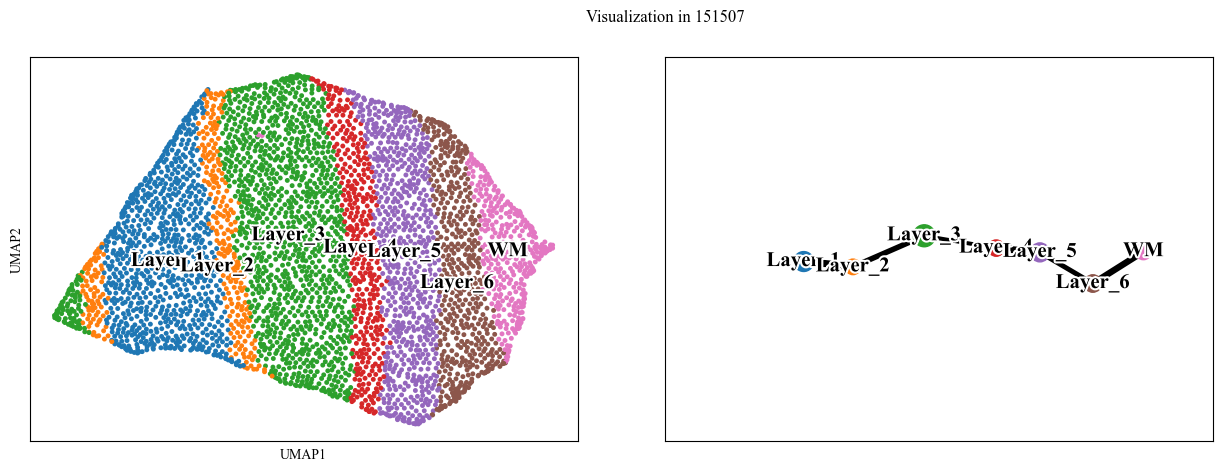

In [3]:
adata = adata[adata.obs['cluster']!='nan', :]

sc.pp.neighbors(adata, use_rep='embedding')
sc.tl.umap(adata)
sc.tl.paga(adata, groups='cluster')

sc.pl.paga_compare(adata, title='Visualization in 151507', legend_fontsize=15, legend_fontoutline=3, size=50, frameon=True)